In [5]:
import numpy as np
import matplotlib.pylab as plt
import uproot
import awkward as ak
import seaborn
import RA_funcs as rf
from scipy.signal import find_peaks

imports work


<!-- <span style="font-family: arial; font-size:25px; color:pink">

Open ROOT file and extract data -->

In [6]:
hit_data_1101 = rf.get_ROOT_data_zip("TB_FIRE_1101_hits.root")

# hit_data_1096 = rf.get_ROOT_data_zip("TB_FIRE_1096_hits.root")

# hit_data_1056 = rf.get_ROOT_data_zip("TB_FIRE_1056_hits.root")

# hit_data_1057 = rf.get_ROOT_data_zip("TB_FIRE_1057_hits.root")

# hit_data_1079 = rf.get_ROOT_data_zip("TB_FIRE_1079_hits.root")

TB_FIRE_1101_hits.root finished


<!-- <span style="font-family: arial; font-size:25px; color:pink">

Hit Counts and Amp in Single Planes -->

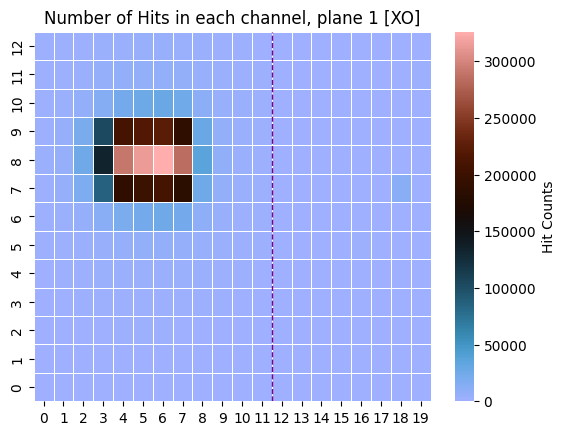

In [3]:
rf.hits_amount_colormap_single_plane(hit_data_1101, 1, cmap="berlin")

In [1]:
# hit_data_1101_with_distances = rf.Radii_from_Initial_position(hit_data_1101)
# rf.frac_energy_radii_histo(hit_data_1101_with_distances, 0.99)

In [7]:



# returns histogram of the energie of events starting at the stated X position
def shower_energy_histo_single_location(hit_data, Position):

    # get only showers starting at the first plane to identify the initial location
    plane_7 = hit_data[hit_data.plane == 7]
    mask = ak.num(plane_7) > 0
    first_plane_starting_events = hit_data[mask]

    # determine the initial location of the shower
    # get the data on the first plane
    plane_7_clean = plane_7[mask]
    plane_7_channel = plane_7_clean.ch

    # divide by x positions
    y, x = divmod(plane_7_channel, 20) #y is the quontinent and is the row, x is the remainder and column
    x_list = x.to_list()
    x_ak = ak.Array(x_list)
    x_avg = ak.mean(x_ak, axis = 1)
    
    # compute the shower energy for each event
    hit_amp_array = first_plane_starting_events.amp
    print(hit_amp_array)
    event_shower_amp_array = ak.sum(hit_amp_array, axis = 1)
    print(event_shower_amp_array)
    
    # get the shower energy for the X position for all events
    amps_divided_by_class, avg_amps, classes = rf.ak_groupby(x_avg, event_shower_amp_array)
    print(amps_divided_by_class)
    
    # div, avg_amps, classes = ak_groupby(x_avg, event_shower_amp_array)
    amps_class_position = amps_divided_by_class[amps_divided_by_class.classes == Position]
    amps_position = amps_class_position.data
    amps_position_clean = ak.flatten(amps_position[ak.num(amps_position) > 0])
    avg_amp = np.round(ak.mean(amps_position_clean))
    print(avg_amp)

    # Plot
    counts, bins = np.histogram(amps_position_clean, bins=7000, range=(0,14000))
    peak_idx = np.argmax(counts)
    peak_center = (bins[peak_idx] + bins[peak_idx + 1]) / 2
    plt.hist(amps_position_clean, bins=7001, range=(0,14000), label=f"avg = {avg_amp} \n peak_bin = {peak_center}")
    plt.grid()
    plt.legend()
    plt.show()


[[39, 27, 183, 73, 435, 83, 38, 63, ..., 71, 558, 48, 156, 20, 161, 155], ...]
[3194, 4498, 5259, 3726, 4791, 6493, ..., 4473, 2979, 4570, 1467, 1657, 470]
[[{classes: 0, data: 3306}, {...}, ..., {...}, {classes: 0, data: 4367}], ...]
4126.0


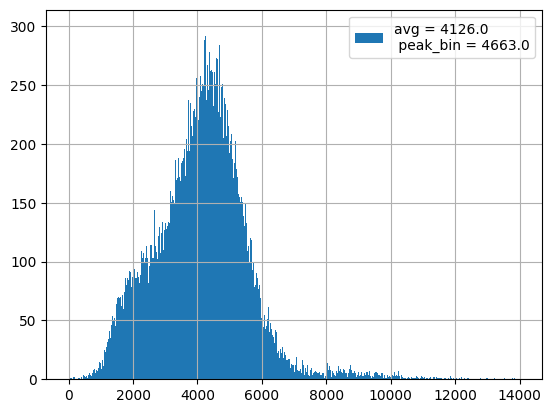

In [8]:
shower_energy_histo_single_location(hit_data_1101, 5)
